<a href="https://colab.research.google.com/github/zjorgx/TelecomXML/blob/main/TELECOM_X_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom X — Predicción de Cancelación (Churn)

## Contenido
1. Preparación de datos
2. Correlación y selección de variables
3. Modelado predictivo
4. Interpretación e importancias


## 1. Preparación de datos

In [21]:
# 1.1 Importaciones y configuración
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Tuple, Dict

# Modelado y preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Balanceo
from imblearn.over_sampling import SMOTE

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

RANDOM_STATE = 42

# 1.2 Carga de datos con fallback (local -> GitHub)

url = "https://raw.githubusercontent.com/zjorgx/TelecomX/refs/heads/main/datos_tratados.csv"
data = pd.read_csv(url)
print("Dimensiones iniciales:", data.shape)
display(data.head(3))

Dimensiones iniciales: (7043, 24)


,ID Cliente,Abandono,Género,Mayor de 65 años,Tiene Pareja,Tiene Dependientes,Duración del Contrato (meses),Servicio Telefónico,Múltiples Líneas,Servicio de Internet,...,TV por Cable,Streaming de Películas,Tipo de Contrato,Facturación Sin Papel,Método de Pago,Costo Mensual,Costo Total,Costo Diario,Rango de Contrato,Cantidad de Servicios Contratados
0,0002-ORFBO,0,F,False,1,1,9,1,0,DSL,...,1,0,Anual,1,Cheque por Correo,65.6,593.30,2.19,0-10,3
1,0003-MKNFE,0,M,False,0,0,9,1,1,DSL,...,0,1,Mensual,0,Cheque por Correo,59.9,542.40,2.00,0-10,2
2,0004-TLHLJ,1,M,False,0,0,4,1,0,Fibra Óptica,...,0,0,Mensual,1,Cheque electrónico,73.9,280.85,2.46,0-10,1


In [22]:
# 1.3 Limpieza básica y preparación
def preparar_datos(df: pd.DataFrame,
                   target_col: str = "Abandono",
                   id_cols: List[str] = ["ID Cliente"]) -> pd.DataFrame:
    # Eliminar identificadores únicos (Paso 1)
    df = df.drop(columns=[c for c in id_cols if c in df.columns], errors="ignore")

    # Asegurar que el target sea binario 0/1 en caso de haber texto
    if df[target_col].dtype == object:
        df[target_col] = df[target_col].astype(str).str.strip().str.lower().map({
            "si": 1, "sí": 1, "yes": 1, "y": 1, "1": 1,
            "no": 0, "n": 0, "0": 0
        }).fillna(df[target_col])
    df[target_col] = df[target_col].astype(int)

    # Identificar columnas categóricas
    cat_cols = df.select_dtypes(include=["object", "bool"]).columns.tolist()
    if target_col in cat_cols:
        cat_cols.remove(target_col)

    # One-Hot Encoding
    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    return df_encoded

data_clean = preparar_datos(data)
print("Dimensiones tras codificación:", data_clean.shape)
display(data_clean.head(3))

Dimensiones tras codificación: (7043, 33)


,Abandono,Tiene Pareja,Tiene Dependientes,Duración del Contrato (meses),Servicio Telefónico,Múltiples Líneas,Seguridad en Línea,Respaldo en Línea,Protección del Dispositivo,Soporte Técnico,...,Método de Pago_Cheque por Correo,Método de Pago_Tarjeta de crédito (automático),Método de Pago_Transferencia bancaria (automático),Rango de Contrato_11-20,Rango de Contrato_21-30,Rango de Contrato_31-40,Rango de Contrato_41-50,Rango de Contrato_51-60,Rango de Contrato_61-70,Rango de Contrato_71+
0,0,1,1,9,1,0,0,1,0,1,...,True,False,False,False,False,False,False,False,False,False
1,0,0,0,9,1,1,0,0,0,0,...,True,False,False,False,False,False,False,False,False,False
2,1,0,0,4,1,0,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False


Proporción de clases (0=no churn, 1=churn):


,conteo,proporcion
Abandono,,
0,5174,0.73463
1,1869,0.26537


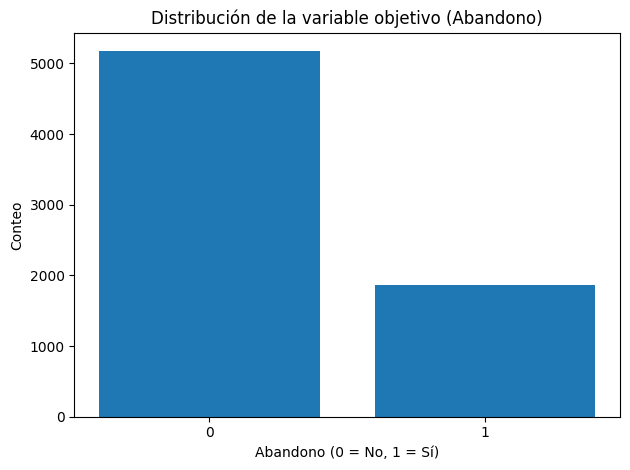

In [23]:
# 1.4 Proporción de clases
def proporcion_clases(df_raw: pd.DataFrame, target: str = "Abandono") -> pd.DataFrame:
    conteo = df_raw[target].value_counts().sort_index()
    prop = df_raw[target].value_counts(normalize=True).sort_index()
    resumen = pd.DataFrame({"conteo": conteo, "proporcion": prop})
    return resumen

resumen_clases = proporcion_clases(data, target="Abandono")
print("Proporción de clases (0=no churn, 1=churn):")
display(resumen_clases)

# Visual de distribución del target
plt.figure()
vals = data["Abandono"].value_counts().sort_index()
plt.bar(vals.index.astype(str), vals.values)
plt.title("Distribución de la variable objetivo (Abandono)")
plt.xlabel("Abandono (0 = No, 1 = Sí)")
plt.ylabel("Conteo")
plt.tight_layout()
plt.show()

In [24]:
# 1.5 División Train/Test
X_full = data_clean.drop("Abandono", axis=1)
y_full = data_clean["Abandono"]

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.3, random_state=RANDOM_STATE, stratify=y_full
)
print("Shapes -> X_train:", X_train.shape, " X_test:", X_test.shape)

Shapes -> X_train: (4930, 32)  X_test: (2113, 32)


In [25]:
# 1.6 Balanceo de clases con SMOTE sobre TRAIN
sm = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Distribución antes SMOTE (train):")
display(y_train.value_counts(normalize=True).to_frame("proporcion"))
print("Distribución después SMOTE (train_res):")
display(y_train_res.value_counts(normalize=True).to_frame("proporcion"))

Distribución antes SMOTE (train):


,proporcion
Abandono,
0,0.734686
1,0.265314


Distribución después SMOTE (train_res):


,proporcion
Abandono,
0,0.5
1,0.5


/tmp/ipython-input-1516561904.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0, g1], labels=["0", "1"], showmeans=True)


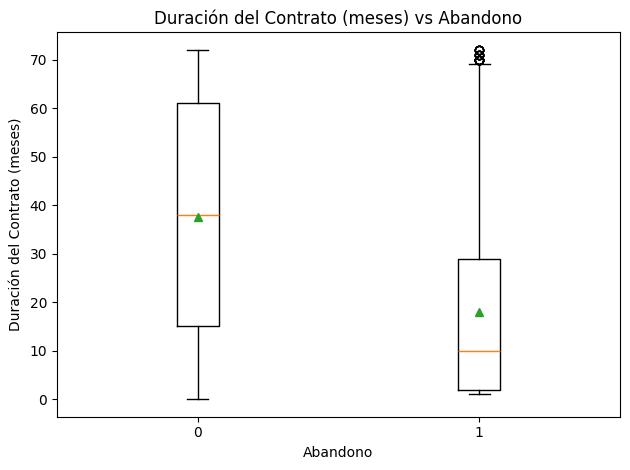

/tmp/ipython-input-1516561904.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0, g1], labels=["0", "1"], showmeans=True)


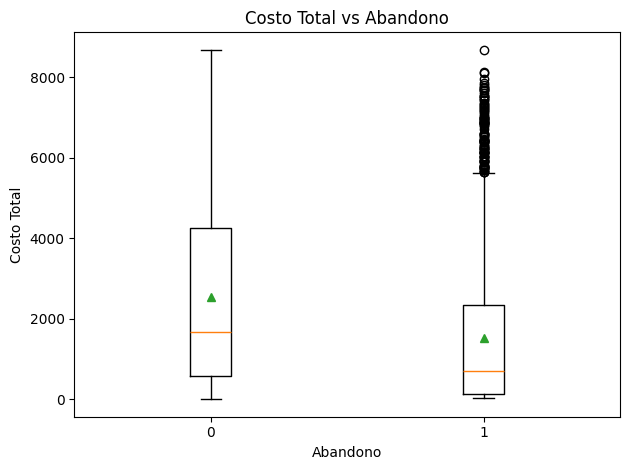

/tmp/ipython-input-1516561904.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0, g1], labels=["0", "1"], showmeans=True)


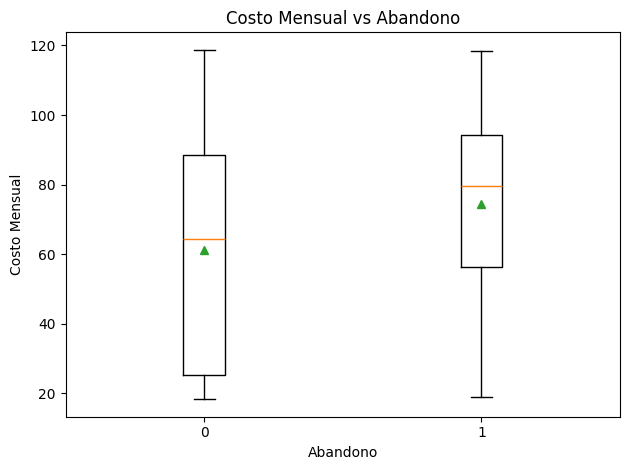

In [26]:
# 1.7 Visualización exploratoria de variables clave
def boxplot_by_target(df: pd.DataFrame, feature: str, target: str = "Abandono", title: str = None):
    if feature not in df.columns:
        return
    g0 = df[df[target] == 0][feature].dropna().values
    g1 = df[df[target] == 1][feature].dropna().values
    if len(g0) == 0 or len(g1) == 0:
        return
    plt.figure()
    plt.boxplot([g0, g1], labels=["0", "1"], showmeans=True)
    plt.title(title or f"{feature} vs {target}")
    plt.xlabel(target); plt.ylabel(feature)
    plt.tight_layout(); plt.show()

for feat in ["Duración del Contrato (meses)", "Costo Total", "Costo Mensual"]:
    if feat in data.columns:
        boxplot_by_target(data, feat, "Abandono", f"{feat} vs Abandono")

In [27]:
# 1.8 Utilidades de evaluación
def evaluar_predicciones(y_true, y_pred) -> Dict[str, float]:
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0)
    }

def plot_confusion_matrix(cm: np.ndarray, title: str = "Matriz de confusión"):
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicción"); plt.ylabel("Real")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["0","1"]); plt.yticks(tick_marks, ["0","1"])
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

## 2. Correlación y selección de variables

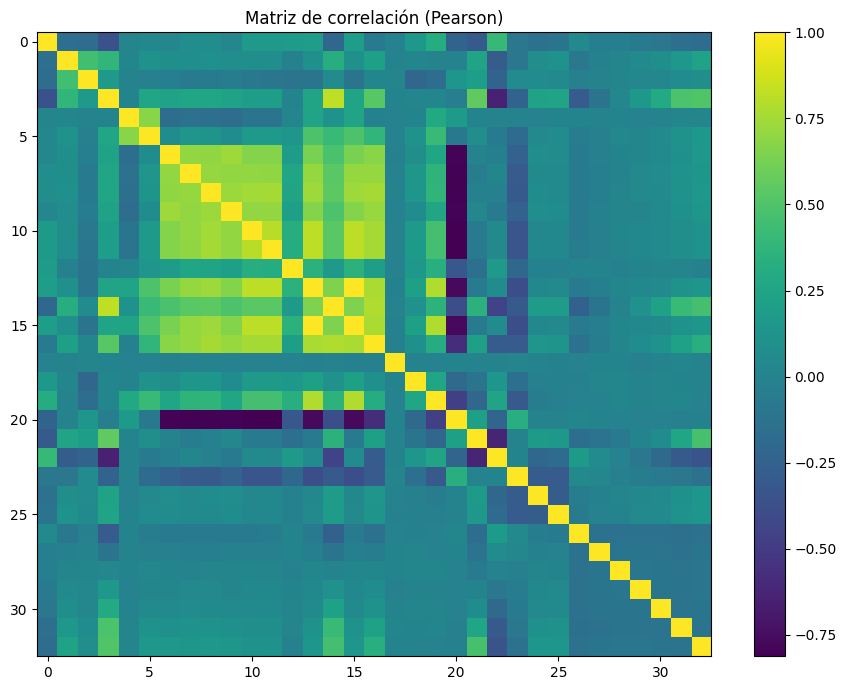

Top correlaciones positivas con Abandono:


,corr
Abandono,1.000000
Tipo de Contrato_Mensual,0.405103
Servicio de Internet_Fibra Óptica,0.308020
Costo Diario,0.193412
Costo Mensual,0.193356
Facturación Sin Papel,0.191825
TV por Cable,0.164673
Streaming de Películas,0.163220
Mayor de 65 años_True,0.150889
Protección del Dispositivo,0.084654


Top correlaciones negativas con Abandono:


,corr
Rango de Contrato_31-40,-0.032471
Rango de Contrato_41-50,-0.060035
Cantidad de Servicios Contratados,-0.069533
Rango de Contrato_51-60,-0.090981
Método de Pago_Cheque por Correo,-0.091683
Método de Pago_Transferencia bancaria (automático),-0.117937
Método de Pago_Tarjeta de crédito (automático),-0.134302
Rango de Contrato_61-70,-0.144254
Tiene Pareja,-0.150448
Tiene Dependientes,-0.164221


Top 20 por Información Mutua con Abandono:


,MI
Tipo de Contrato_Mensual,0.100138
Duración del Contrato (meses),0.068286
Seguridad en Línea,0.065477
Tipo de Contrato_Bianual,0.060430
Soporte Técnico,0.059504
Servicio de Internet_Fibra Óptica,0.052165
Streaming de Películas,0.049739
Costo Mensual,0.049569
Respaldo en Línea,0.048384
Costo Diario,0.047974


Señalamos 60 features con mayor MI para análisis opcional.


In [28]:
from sklearn.feature_selection import mutual_info_classif

# 2.1 Matriz de correlación para numéricas
corr = data_clean.corr(numeric_only=True)
plt.figure(figsize=(9,7))
plt.imshow(corr.values, aspect="auto")
plt.title("Matriz de correlación (Pearson)")
plt.colorbar()
plt.tight_layout()
plt.show()

# Top correlaciones con el target
corr_target = corr["Abandono"].sort_values(ascending=False)
print("Top correlaciones positivas con Abandono:")
display(corr_target.head(15).to_frame("corr"))
print("Top correlaciones negativas con Abandono:")
display(corr_target.tail(15).to_frame("corr"))

# 2.2 Información mutua (no lineal)
X_tmp = data_clean.drop("Abandono", axis=1)
y_tmp = data_clean["Abandono"]
mi = mutual_info_classif(X_tmp, y_tmp, random_state=RANDOM_STATE)
mi_series = pd.Series(mi, index=X_tmp.columns).sort_values(ascending=False)
print("Top 20 por Información Mutua con Abandono:")
display(mi_series.head(20).to_frame("MI"))

# 2.3 Selección opcional (marcamos TOP_K para análisis)
TOP_K_MI = 60
features_top_mi = mi_series.head(TOP_K_MI).index.tolist()
print(f"Señalamos {TOP_K_MI} features con mayor MI para análisis opcional.")

## 3. Modelado predictivo

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Mejores hiperparámetros (Logística): {'log__class_weight': None, 'log__C': 1.0}
Mejor F1 medio CV: 0.8330
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Mejores hiperparámetros (KNN): {'knn__weights': 'distance', 'knn__n_neighbors': 11}
Mejor F1 medio CV: 0.8330
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Mejores hiperparámetros (SVM Lineal): {'svm_lin__C': 0.5}
Mejor F1 medio CV: 0.8312
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Mejores hiperparámetros (SVM RBF): {'svm_rbf__gamma': 'scale', 'svm_rbf__C': 2.0}
Mejor F1 medio CV: 0.8424
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Mejores hiperparámetros (Random Forest): {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20, 'class_weight': None}
Mejor F1 medio CV: 0.8524

== Regresión Logística ==
Accuracy: 0.7544
Precision: 0.5285
Recall: 0.6934
F1: 0.5998
AUC_ROC: 0.8268
Matriz de confusión:
[[1205  347]
 [ 172  389]]
              precision    recall  f1-score   support

           0       0.88      0.78      0.82      1552
           1       0.53      0.69      0.60       561

    accuracy                           0.75      2113
   macro avg       0.70      0.73      0.71      2113
weighted avg       0.78      0.75      0.76      2113



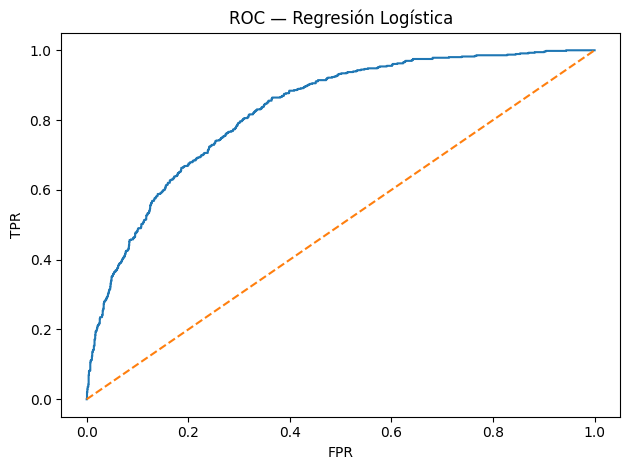

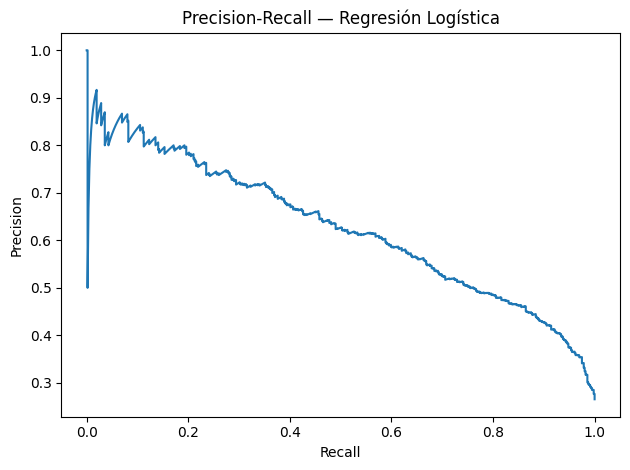

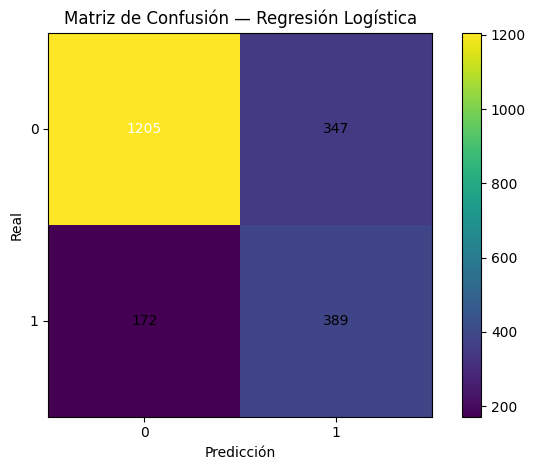


== KNN ==
Accuracy: 0.7302
Precision: 0.4941
Recall: 0.6702
F1: 0.5688
AUC_ROC: nan
Matriz de confusión:
[[1167  385]
 [ 185  376]]
              precision    recall  f1-score   support

           0       0.86      0.75      0.80      1552
           1       0.49      0.67      0.57       561

    accuracy                           0.73      2113
   macro avg       0.68      0.71      0.69      2113
weighted avg       0.77      0.73      0.74      2113



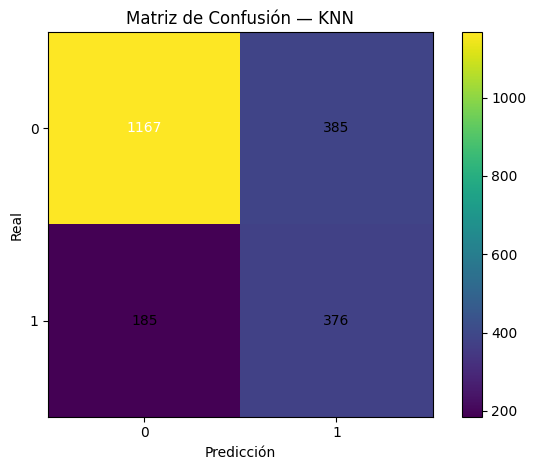


== SVM Lineal ==
Accuracy: 0.7558
Precision: 0.5300
Recall: 0.7077
F1: 0.6061
AUC_ROC: 0.8256
Matriz de confusión:
[[1200  352]
 [ 164  397]]
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1552
           1       0.53      0.71      0.61       561

    accuracy                           0.76      2113
   macro avg       0.70      0.74      0.71      2113
weighted avg       0.79      0.76      0.77      2113



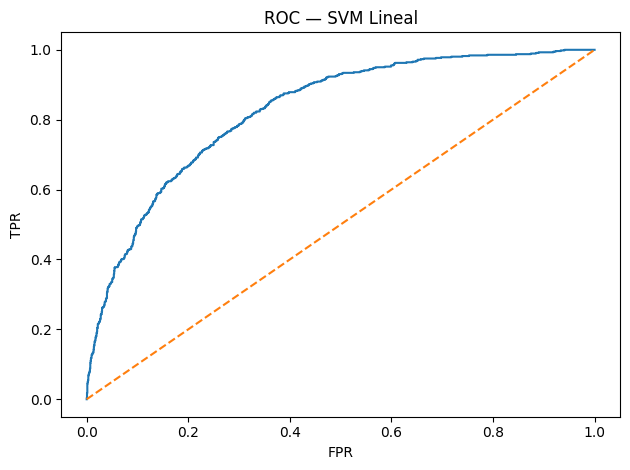

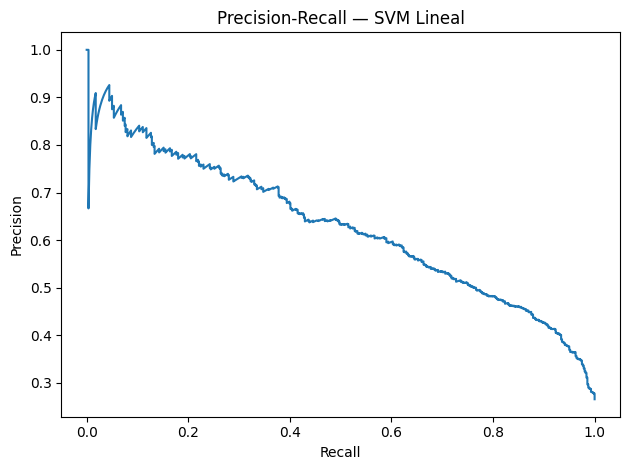

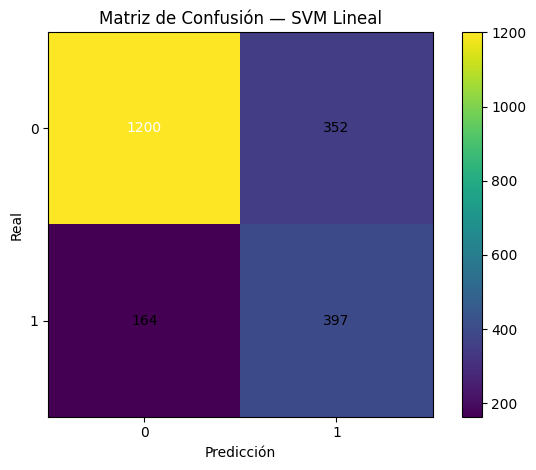


== SVM RBF ==
Accuracy: 0.7667
Precision: 0.5483
Recall: 0.6881
F1: 0.6103
AUC_ROC: 0.8169
Matriz de confusión:
[[1234  318]
 [ 175  386]]
              precision    recall  f1-score   support

           0       0.88      0.80      0.83      1552
           1       0.55      0.69      0.61       561

    accuracy                           0.77      2113
   macro avg       0.71      0.74      0.72      2113
weighted avg       0.79      0.77      0.77      2113



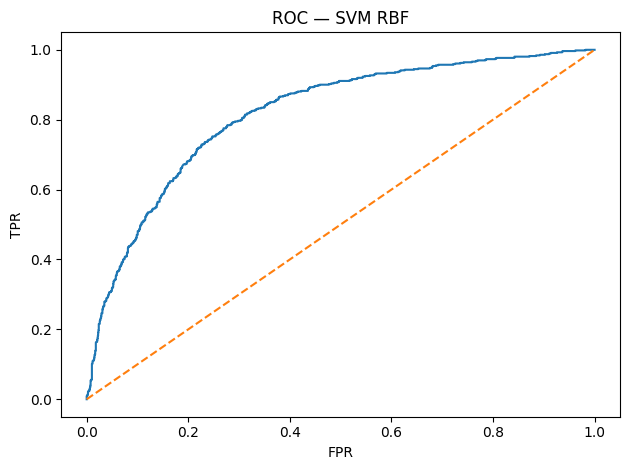

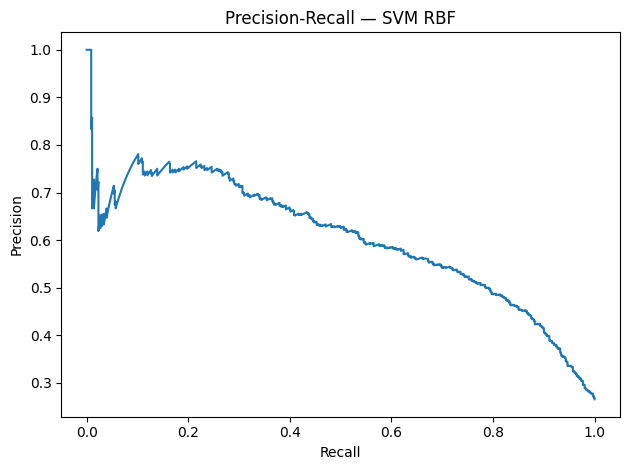

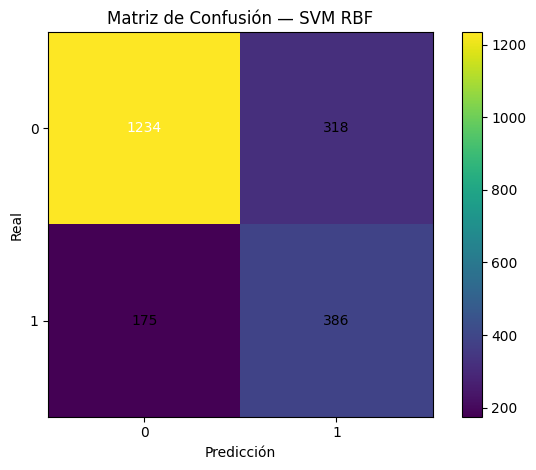


== Random Forest ==
Accuracy: 0.7728
Precision: 0.5652
Recall: 0.6257
F1: 0.5939
AUC_ROC: 0.8273
Matriz de confusión:
[[1282  270]
 [ 210  351]]
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1552
           1       0.57      0.63      0.59       561

    accuracy                           0.77      2113
   macro avg       0.71      0.73      0.72      2113
weighted avg       0.78      0.77      0.78      2113



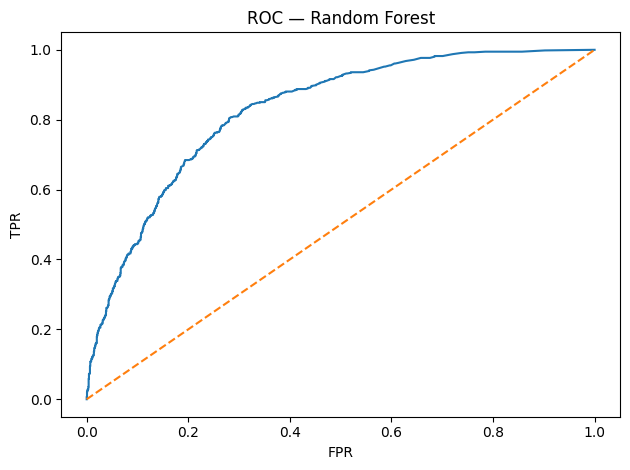

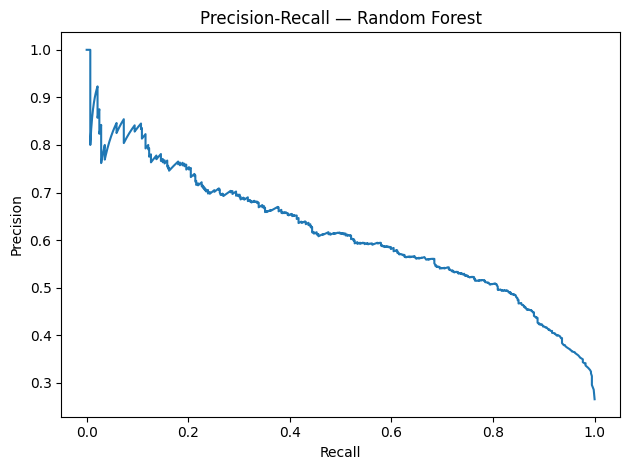

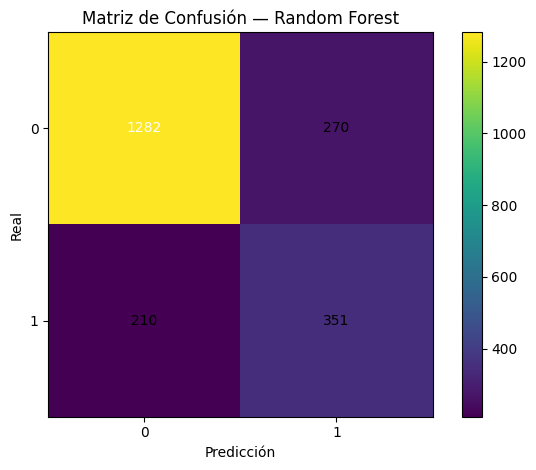


Comparación de resultados en TEST (ordenado por F1, luego AUC_ROC):


,Modelo,Accuracy,Precision,Recall,F1,AUC_ROC,AUC_PR
3,SVM RBF,0.766682,0.548295,0.688057,0.610277,0.816898,0.603406
2,SVM Lineal,0.755797,0.530040,0.707665,0.606107,0.825639,0.627508
0,Regresión Logística,0.754378,0.528533,0.693405,0.599846,0.826841,0.625198
4,Random Forest,0.772835,0.565217,0.625668,0.593909,0.827267,0.614886
1,KNN,0.730241,0.494087,0.670232,0.568835,NaN,NaN


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 3.1 Pipelines base
pipe_log = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("log", LogisticRegression(max_iter=4000, random_state=RANDOM_STATE))
])

pipe_knn = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("knn", KNeighborsClassifier())
])

pipe_svm_lin = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("svm_lin", LinearSVC(random_state=RANDOM_STATE, max_iter=6000))
])

pipe_svm_rbf = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("svm_rbf", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))
])

rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

# 3.2 Espacios reducidos de hiperparámetros
param_dist_log = {
    "log__C": [0.1, 1.0, 3.0],
    "log__class_weight": [None, "balanced"]
}
param_dist_knn = {
    "knn__n_neighbors": [5, 11, 21],
    "knn__weights": ["uniform", "distance"]
}
param_dist_svm_lin = {"svm_lin__C": [0.5, 1.0, 2.0]}
param_dist_svm_rbf = {
    "svm_rbf__C": [0.5, 1.0, 2.0],
    "svm_rbf__gamma": ["scale", "auto"]
}
param_dist_rf = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "class_weight": [None, "balanced_subsample"]
}

# 3.3 Utilidades con RandomizedSearchCV
def random_fit(model, param_dist, Xtr, ytr, cv_splits=3, nombre="RandomSearch", n_iter=10):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)
    rs = RandomizedSearchCV(
        model, param_distributions=param_dist, n_iter=n_iter,
        scoring="f1", cv=cv, n_jobs=-1, refit=True, random_state=RANDOM_STATE, verbose=2
    )
    rs.fit(Xtr, ytr)
    print(f"\nMejores hiperparámetros ({nombre}): {rs.best_params_}")
    print(f"Mejor F1 medio CV: {rs.best_score_:.4f}")
    return rs.best_estimator_

def entrenar_y_evaluar(model, Xtr, Xte, ytr, yte, nombre="Modelo", proba_ok=True):
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)
    y_score = None
    if proba_ok and hasattr(model, "predict_proba"):
        y_score = model.predict_proba(Xte)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(Xte)

    evals = evaluar_predicciones(yte, y_pred)
    auc_roc = roc_auc_score(yte, y_score) if y_score is not None else np.nan
    evals["AUC_ROC"] = auc_roc

    cm = confusion_matrix(yte, y_pred)
    print(f"\n== {nombre} ==")
    for k,v in evals.items():
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")
    print("Matriz de confusión:")
    print(cm)
    print(classification_report(yte, y_pred, zero_division=0))

    if y_score is not None:
        fpr, tpr, _ = roc_curve(yte, y_score)
        prec, rec, _ = precision_recall_curve(yte, y_score)
        auc_pr = auc(rec, prec)
        evals["AUC_PR"] = auc_pr

        plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1], linestyle="--")
        plt.title(f"ROC — {nombre}"); plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.tight_layout(); plt.show()

        plt.figure(); plt.plot(rec, prec)
        plt.title(f"Precision-Recall — {nombre}"); plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.tight_layout(); plt.show()

    plot_confusion_matrix(cm, title=f"Matriz de Confusión — {nombre}")
    return evals, model

# 3.4 RandomSearch en TRAIN_RES (balanceado)
best_log = random_fit(pipe_log, param_dist_log, X_train_res, y_train_res, cv_splits=3, nombre="Logística")
best_knn = random_fit(pipe_knn, param_dist_knn, X_train_res, y_train_res, cv_splits=3, nombre="KNN")
best_svm_lin = random_fit(pipe_svm_lin, param_dist_svm_lin, X_train_res, y_train_res, cv_splits=3, nombre="SVM Lineal")
best_svm_rbf = random_fit(pipe_svm_rbf, param_dist_svm_rbf, X_train_res, y_train_res, cv_splits=3, nombre="SVM RBF")
best_rf = random_fit(rf, param_dist_rf, X_train_res, y_train_res, cv_splits=3, nombre="Random Forest")

# 3.5 Evaluación en TEST (no balanceado)
resultados = {}
res_log, m_log = entrenar_y_evaluar(best_log, X_train_res, X_test, y_train_res, y_test, "Regresión Logística", proba_ok=True); resultados["Regresión Logística"] = res_log
res_knn, m_knn = entrenar_y_evaluar(best_knn, X_train_res, X_test, y_train_res, y_test, "KNN", proba_ok=False); resultados["KNN"] = res_knn
res_svm_lin, m_svm_lin = entrenar_y_evaluar(best_svm_lin, X_train_res, X_test, y_train_res, y_test, "SVM Lineal", proba_ok=False); resultados["SVM Lineal"] = res_svm_lin
res_svm_rbf, m_svm_rbf = entrenar_y_evaluar(best_svm_rbf, X_train_res, X_test, y_train_res, y_test, "SVM RBF", proba_ok=True); resultados["SVM RBF"] = res_svm_rbf
res_rf, m_rf = entrenar_y_evaluar(best_rf, X_train_res, X_test, y_train_res, y_test, "Random Forest", proba_ok=True); resultados["Random Forest"] = res_rf

# 3.6 Comparativa consolidada
df_resultados = pd.DataFrame([{"Modelo": k, **v} for k, v in resultados.items()]).sort_values(["F1", "AUC_ROC"], ascending=False)
print("\nComparación de resultados en TEST (ordenado por F1, luego AUC_ROC):")
display(df_resultados)


== XGBoost ==
Accuracy: 0.7714
Precision: 0.5633
Recall: 0.6185
F1: 0.5896
AUC_ROC: 0.8221
AUC_PR: 0.6275
Matriz de confusión:
 [[1283  269]
 [ 214  347]]
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1552
           1       0.56      0.62      0.59       561

    accuracy                           0.77      2113
   macro avg       0.71      0.72      0.72      2113
weighted avg       0.78      0.77      0.77      2113



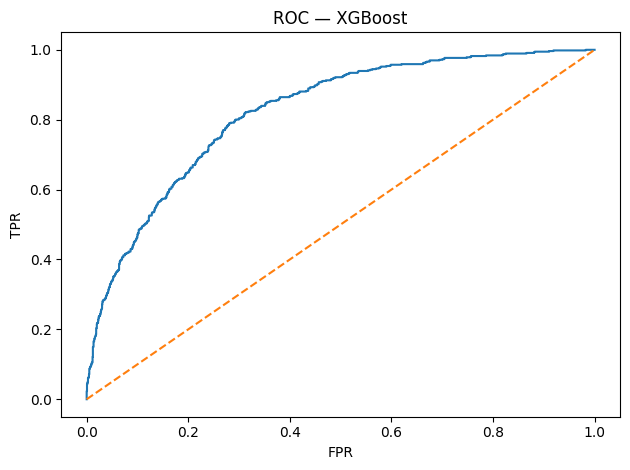

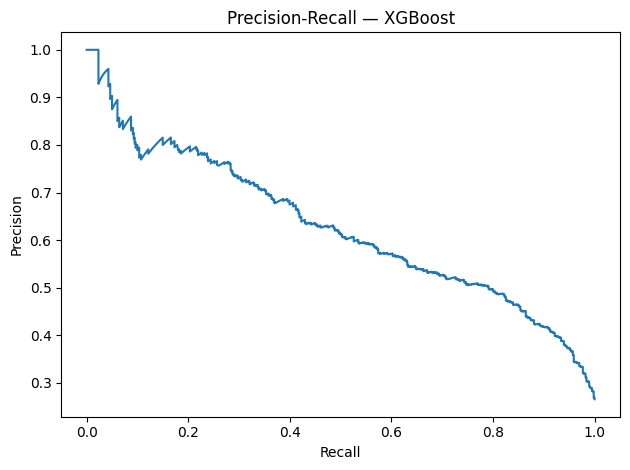

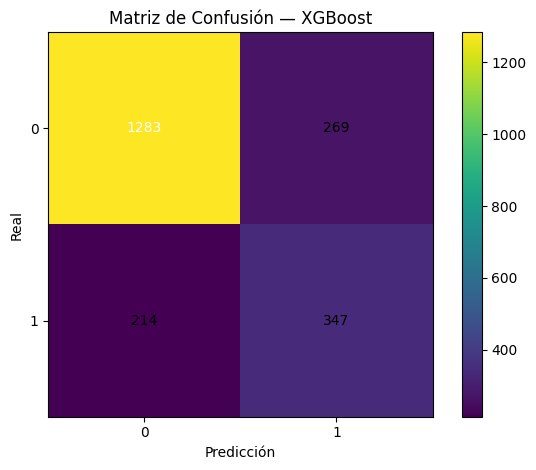


Comparación incluyendo XGBoost:


,Modelo,Accuracy,Precision,Recall,F1,AUC_ROC,AUC_PR
3,SVM RBF,0.766682,0.548295,0.688057,0.610277,0.816898,0.603406
2,SVM Lineal,0.755797,0.530040,0.707665,0.606107,0.825639,0.627508
0,Regresión Logística,0.754378,0.528533,0.693405,0.599846,0.826841,0.625198
4,Random Forest,0.772835,0.565217,0.625668,0.593909,0.827267,0.614886
5,XGBoost,0.771415,0.563312,0.618538,0.589635,0.822066,0.627480
1,KNN,0.730241,0.494087,0.670232,0.568835,NaN,NaN


In [31]:
# 3.7 (Opcional) XGBoost
try:
    from xgboost import XGBClassifier
    xgb = XGBClassifier(
        n_estimators=500, max_depth=5, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, random_state=RANDOM_STATE,
        n_jobs=-1, reg_lambda=1.0, reg_alpha=0.0, tree_method="hist"
    )
    xgb.fit(X_train_res, y_train_res)
    y_pred = xgb.predict(X_test)
    y_proba = xgb.predict_proba(X_test)[:,1]

    from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
    evals_xgb = evaluar_predicciones(y_test, y_pred)
    evals_xgb["AUC_ROC"] = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    evals_xgb["AUC_PR"] = auc(rec, prec)

    print("\n== XGBoost ==")
    for k,v in evals_xgb.items():
        print(f"{k}: {v:.4f}")
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión:\n", cm)
    print(classification_report(y_test, y_pred, zero_division=0))

    plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1], linestyle="--")
    plt.title("ROC — XGBoost"); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.tight_layout(); plt.show()

    plt.figure(); plt.plot(rec, prec)
    plt.title("Precision-Recall — XGBoost"); plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.tight_layout(); plt.show()

    plot_confusion_matrix(cm, "Matriz de Confusión — XGBoost")

    resultados["XGBoost"] = evals_xgb
    df_resultados = pd.DataFrame([{"Modelo": k, **v} for k,v in resultados.items()]).sort_values(["F1","AUC_ROC"], ascending=False)
    print("\nComparación incluyendo XGBoost:")
    display(df_resultados)

except Exception as e:
    print("XGBoost no disponible o falló la importación/ajuste:", e)

## 4. Interpretación e importancias

Permutation Importance KNN no disponible: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Rango de Contrato_71+
- Servicio de Internet_No internet service



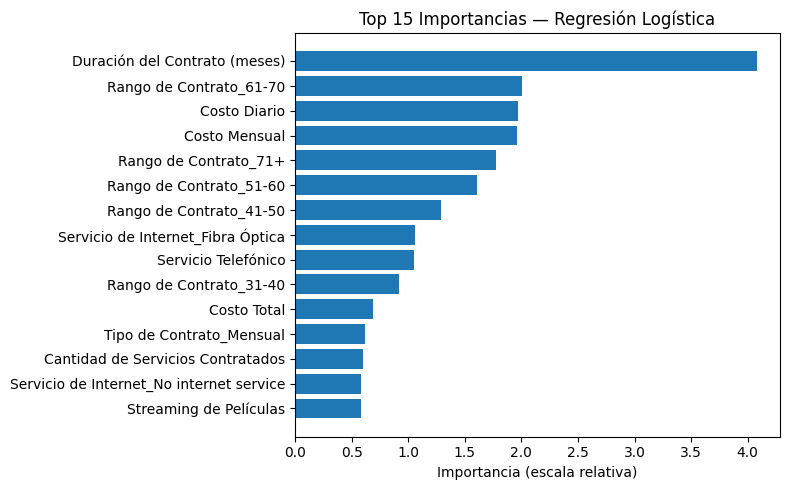

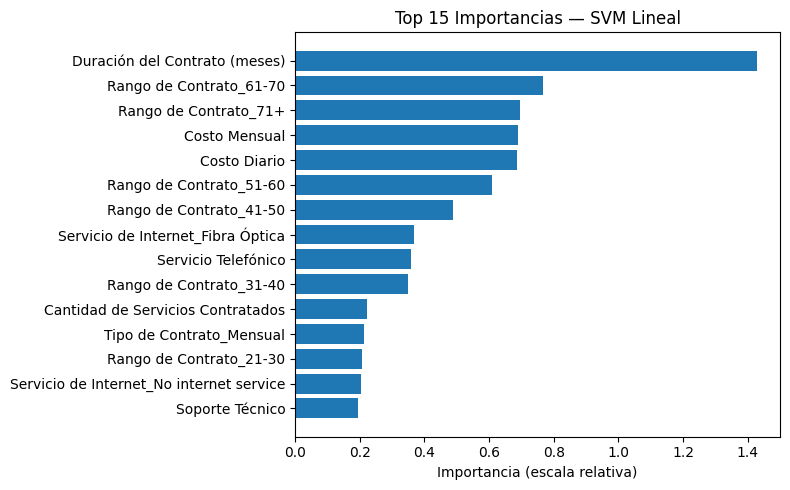

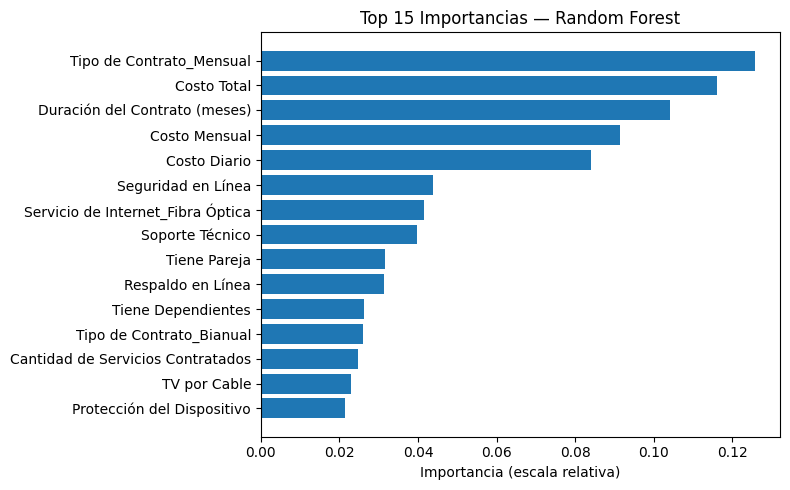

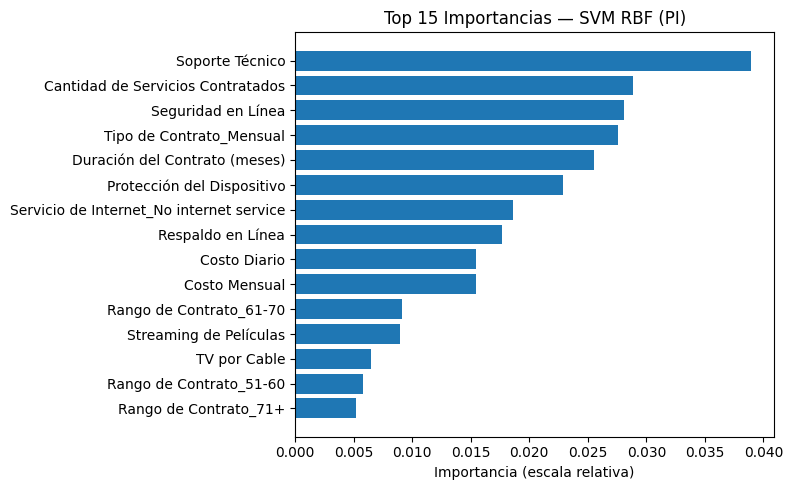

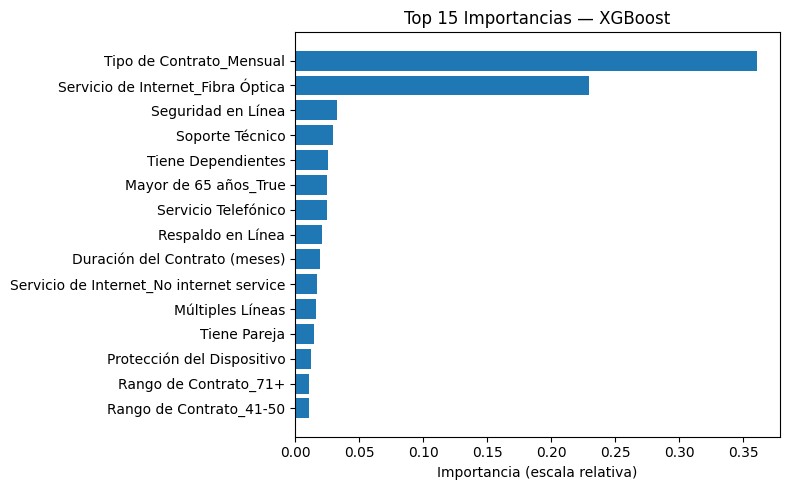


Factores comunes destacados (intersección Top-10 entre modelos disponibles):
['Duración del Contrato (meses)']

Resumen final de modelos (ordenado por F1 y AUC_ROC):


,Modelo,Accuracy,Precision,Recall,F1,AUC_ROC,AUC_PR
3,SVM RBF,0.766682,0.548295,0.688057,0.610277,0.816898,0.603406
2,SVM Lineal,0.755797,0.530040,0.707665,0.606107,0.825639,0.627508
0,Regresión Logística,0.754378,0.528533,0.693405,0.599846,0.826841,0.625198
4,Random Forest,0.772835,0.565217,0.625668,0.593909,0.827267,0.614886
5,XGBoost,0.771415,0.563312,0.618538,0.589635,0.822066,0.627480
1,KNN,0.730241,0.494087,0.670232,0.568835,NaN,NaN



Mejor modelo por F1/AUC global: SVM RBF

Análisis crítico:
- Si Random Forest o XGBoost superan ampliamente al resto, hay no linealidades e interacciones importantes.
- Si Regresión Logística rinde cercano al mejor, la relación puede ser aproximadamente lineal.
- Si KNN baja en F1/AUC, revisar normalización y parámetro K.
- SVM RBF alto sugiere fronteras no lineales; ajustar C y gamma para controlar complejidad.

Recomendaciones de retención (ajustar según resultados):
- Incentivar contratos de mayor duración si menor 'Duración del Contrato (meses)' es importante.
- Ofrecer bundles/descuentos a clientes con 'Costo Mensual' o 'Costo Total' altos.
- Fortalecer soporte/backup/seguridad si su ausencia está asociada a churn.
- Intervenciones por 'Tipo de Contrato' o 'Método de Pago' si aparecen entre las top variables.


In [32]:
from sklearn.inspection import permutation_importance

# 4.1 Importancias/coeficientes por modelo
feature_names = X_full.columns.tolist()

def top_importancias_series(serie: pd.Series, top: int = 15) -> pd.Series:
    if serie is None or len(serie) == 0:
        return pd.Series(dtype=float)
    return serie.sort_values(ascending=False).head(top)

importancias = {}

# Regresión Logística: coeficientes absolutos
try:
    coef_log = m_log.named_steps["log"].coef_.ravel()
    imp_log = pd.Series(np.abs(coef_log), index=feature_names)
    importancias["Regresión Logística"] = imp_log
except Exception as e:
    print("Importancias Logística no disponibles:", e)

# SVM lineal: coeficientes absolutos
try:
    coef_svm = m_svm_lin.named_steps["svm_lin"].coef_.ravel()
    imp_svm = pd.Series(np.abs(coef_svm), index=feature_names)
    importancias["SVM Lineal"] = imp_svm
except Exception as e:
    print("Importancias SVM Lineal no disponibles:", e)

# Random Forest: feature_importances_
try:
    imp_rf = pd.Series(m_rf.feature_importances_, index=feature_names)
    importancias["Random Forest"] = imp_rf
except Exception as e:
    print("Importancias Random Forest no disponibles:", e)

# SVM RBF: Permutation Importance
try:
    pi_svm_rbf = permutation_importance(best_svm_rbf, X_test, y_test, n_repeats=3,
                                        random_state=RANDOM_STATE, n_jobs=-1)
    importancias["SVM RBF (PI)"] = pd.Series(pi_svm_rbf.importances_mean, index=feature_names)
except Exception as e:
    print("Permutation Importance SVM RBF no disponible:", e)

# KNN: Permutation Importance con top-30 de RF
try:
    top_feats_rf = top_importancias_series(importancias.get("Random Forest", pd.Series(dtype=float)), 30).index.tolist()
    if len(top_feats_rf) > 0:
        pi_knn = permutation_importance(best_knn, X_test[top_feats_rf], y_test, n_repeats=3,
                                        random_state=RANDOM_STATE, n_jobs=-1)
        importancias["KNN (PI top-30 RF)"] = pd.Series(pi_knn.importances_mean, index=top_feats_rf)
except Exception as e:
    print("Permutation Importance KNN no disponible:", e)

# XGBoost: si se entrenó
try:
    if "XGBoost" in resultados:
        from xgboost import XGBClassifier
        imp_xgb = pd.Series(xgb.feature_importances_, index=feature_names)
        importancias["XGBoost"] = imp_xgb
except Exception as e:
    pass

# 4.2 Visualización Top-15 por modelo
def plot_importancias(serie_imp: pd.Series, titulo: str, top: int = 15):
    s = top_importancias_series(serie_imp, top)
    if s.empty:
        return
    idx = np.arange(len(s))
    plt.figure(figsize=(8,5))
    plt.barh(idx, s.values)
    plt.yticks(idx, s.index)
    plt.gca().invert_yaxis()
    plt.title(titulo)
    plt.xlabel("Importancia (escala relativa)")
    plt.tight_layout()
    plt.show()

for nombre, serie in importancias.items():
    plot_importancias(serie, f"Top 15 Importancias — {nombre}", top=15)

# 4.3 Factores comunes entre modelos
conjuntos = [set(top_importancias_series(s, 10).index) for s in importancias.values() if s is not None and not s.empty]
factores_comunes = set.intersection(*conjuntos) if len(conjuntos) >= 2 else (next(iter(conjuntos)) if conjuntos else set())
print("\nFactores comunes destacados (intersección Top-10 entre modelos disponibles):")
print(list(factores_comunes))

# 4.4 Resumen final de modelos
df_final = pd.DataFrame([{"Modelo": k, **v} for k, v in resultados.items()])
df_final = df_final.sort_values(["F1", "AUC_ROC"], ascending=False)
print("\nResumen final de modelos (ordenado por F1 y AUC_ROC):")
display(df_final)

mejor_modelo = df_final.iloc[0]["Modelo"]
print(f"\nMejor modelo por F1/AUC global: {mejor_modelo}")

print("\nAnálisis crítico:")
print("- Si Random Forest o XGBoost superan ampliamente al resto, hay no linealidades e interacciones importantes.")
print("- Si Regresión Logística rinde cercano al mejor, la relación puede ser aproximadamente lineal.")
print("- Si KNN baja en F1/AUC, revisar normalización y parámetro K.")
print("- SVM RBF alto sugiere fronteras no lineales; ajustar C y gamma para controlar complejidad.")

print("\nRecomendaciones de retención (ajustar según resultados):")
print("- Incentivar contratos de mayor duración si menor 'Duración del Contrato (meses)' es importante.")
print("- Ofrecer bundles/descuentos a clientes con 'Costo Mensual' o 'Costo Total' altos.")
print("- Fortalecer soporte/backup/seguridad si su ausencia está asociada a churn.")
print("- Intervenciones por 'Tipo de Contrato' o 'Método de Pago' si aparecen entre las top variables.")
